In [0]:
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import cv2
import numpy as np 
from tensorflow.python.framework import graph_util
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

In [106]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
data1='/content/drive/My Drive/fintest/1coal'
data2='/content/drive/My Drive/fintest/2coal'
data3='/content/drive/My Drive/fintest/3coal'

In [0]:
def data_with_label():
    images=[]
    cnt = 0
    for i in tqdm(os.listdir(data1)):
        path=os.path.join(data1,i)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(64,64))
        images.append([np.array(img),np.array([1,0,0])])
    cnt = 0
    for i in tqdm(os.listdir(data2)):
        path=os.path.join(data2,i)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(64,64))
        images.append([np.array(img),np.array([0,1,0])])
    cnt = 0
    for i in tqdm(os.listdir(data3)):
        path=os.path.join(data3,i)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(64,64))
        images.append([np.array(img),np.array([0,0,1])])

    return images

In [110]:
data = data_with_label()

100%|██████████| 446/446 [07:50<00:00,  1.06s/it]


In [0]:
import random
random.shuffle(data)
train_data, test_data = train_test_split(data, test_size=0.2)

In [0]:
tr_img_data = np.array([i[0] for i in train_data]).reshape(-1,64,64,1)
tr_img_data = tr_img_data/255
tr_lbl_data = np.array([i[1] for i in train_data])
tst_img_data = np.array([i[0] for i in test_data]).reshape(-1,64,64,1)
tst_img_data = tst_img_data/255
tst_lbl_data = np.array([i[1] for i in test_data])

In [154]:
def create_model():
    model=Sequential()
    model.add(InputLayer(input_shape=[64,64,1]))

    model.add(Conv2D(filters=16,kernel_size=3,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01),strides=1,padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=3,padding='same'))
              
    model.add(Conv2D(filters=16,kernel_size=3,strides=2,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01), padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=3,padding='same'))         

    model.add(Flatten())

    model.add(Dense(2048,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01),activation='relu'))
    model.add(Dropout(0.80))

    model.add(Dense(512,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.01),activation='relu'))
    model.add(Dropout(0.70))
    model.add(Dense(3,activation='softmax'))
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
              
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
    return model
model = create_model()
model.summary()


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 11, 11, 16)        2320      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 2048)              526336    
_________________________________________________________________
dropout_67 (Dropout)         (None, 2048)            

In [157]:
import keras 
checkpoint_path = "/content/drive/My Drive/cnn_mod.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
history = model.fit(tr_img_data, 
          tr_lbl_data,  
          epochs=150,
          batch_size=32,
          validation_data=(tst_img_data,tst_lbl_data),
          callbacks=[cp_callback])  # Pass callback to training


Train on 908 samples, validate on 227 samples
Epoch 1/150
908/908 [==============================] - 2s 2ms/step - loss: 2.3542 - accuracy: 0.3491 - val_loss: 2.2590 - val_accuracy: 0.3921

Epoch 00001: saving model to /content/drive/My Drive/cnn_mod.ckpt
Epoch 2/150
908/908 [==============================] - 0s 458us/step - loss: 2.2307 - accuracy: 0.3877 - val_loss: 2.1679 - val_accuracy: 0.3921

Epoch 00002: saving model to /content/drive/My Drive/cnn_mod.ckpt
Epoch 3/150
908/908 [==============================] - 0s 458us/step - loss: 2.1338 - accuracy: 0.4196 - val_loss: 2.0891 - val_accuracy: 0.3921

Epoch 00003: saving model to /content/drive/My Drive/cnn_mod.ckpt
Epoch 4/150
908/908 [==============================] - 0s 479us/step - loss: 2.0708 - accuracy: 0.3756 - val_loss: 2.0188 - val_accuracy: 0.3921

Epoch 00004: saving model to /content/drive/My Drive/cnn_mod.ckpt
Epoch 5/150
908/908 [==============================] - 0s 458us/step - loss: 2.0065 - accuracy: 0.3756 - val

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


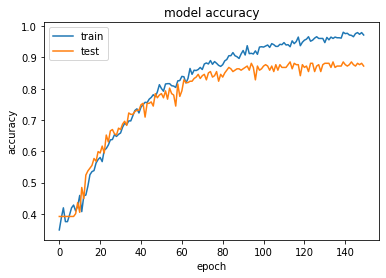

In [158]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])#,history.history['val_acc'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


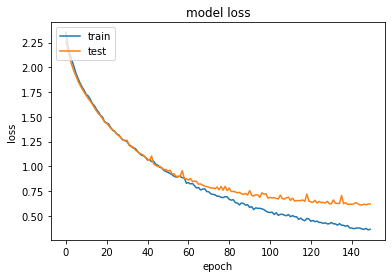

In [159]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [160]:
# Create a basic model instance
model = create_model()

# Evaluate the model
loss, acc = model.evaluate(tst_img_data,  tst_lbl_data, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

Untrained model, accuracy: 40.09%


In [161]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss,acc = model.evaluate(tst_img_data,  tst_lbl_data, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Restored model, accuracy: 87.22%
